# Quiz Two

## Your Name: Aiden Belt

## Instructions:
Solve all problems in python to the best of your ability. You are welcome to use Excel in order to check your answers, but you must submit a python notebook exported as an html file to receive full credit. Furthermore, feel free to collaborate with your fellow classmates. You need to turn in your own copy of the notebook. Make sure your name is on the top of the notebook and is visible when you export it to html.

### Due Date: Wednesday, March 17 2023 at 11.59pm

In [1]:
import pandas as pd
import pyomo.environ as pe
import matplotlib.pyplot as plt
import seaborn as sns

## Problem One: Flavors

In this problem, we have five flavors of products that we can make: Apple, Banana, Chocolate, Elderberry, and Fig. The price for each product is listed along with the expected price if they are produced. We want to maximize our profit and determine how many of each product we should make. The data are given in the `flavors` tab of the `quiz-2.xlsx` spreadsheet. Note that there are both Fixed and Variable Costs because we do not have to make each product. 

In [2]:
flav_data = pd.read_excel('q2.xlsx', 
                         sheet_name = 'flavors', usecols = 'B:H')
flav_data

,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Units Required,Apple,Banana,Chocolate,Elderberry,Fig,Units Available
2,Mixing,5,6,7,3,4,2700
3,Preparation,3,5,6,6,6,2700
4,Blending,4,4,4,3,4,2500
5,Packaging,2,3,3,5,5,2500
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,Apple,Banana,Chocolate,Elderberry,Fig,NaN
8,Fixed Setup cost,60,78,91,40,40,NaN
9,Cost/unit ($),3.2,3.7,3.9,3.8,3.1,NaN


### Problem 1a

How many of each product (flavor) should we produce in order to maximize profit? 

In [3]:
flav_indexes = ['Apple', 'Banana', 'Chocolate', 'Elderberry', 'Fig']

In [4]:
flav_coef = pd.DataFrame(flav_data.iloc[[2, 3, 4, 5, 8, 9, 10], 1:6])
flav_coef.index = ['mixing', 'preparation', 'blending', 'packaging', 'fixed cost', 'cost/unit', 'price/unit']
flav_coef.loc['profit/unit'] = flav_coef.loc['price/unit'] - flav_coef.loc['cost/unit']
flav_coef.columns = flav_indexes
flav_coef

,Apple,Banana,Chocolate,Elderberry,Fig
mixing,5,6,7,3,4
preparation,3,5,6,6,6
blending,4,4,4,3,4
packaging,2,3,3,5,5
fixed cost,60,78,91,40,40
cost/unit,3.2,3.7,3.9,3.8,3.1
price/unit,5.5,6.2,4.5,3.9,5.1
profit/unit,2.3,2.5,0.6,0.1,2.0


In [5]:
flav_rhs = pd.DataFrame(flav_data.iloc[2:6, 6])
flav_rhs.index = ['mixing', 'preparation', 'blending', 'packaging']
flav_rhs.loc['demand'] = 200
flav_rhs.columns = ['rhs']
flav_rhs

,rhs
mixing,2700
preparation,2700
blending,2500
packaging,2500
demand,200


In [6]:
model = pe.ConcreteModel()

In [7]:
model.x = pe.Var(flav_indexes, domain = pe.NonNegativeIntegers)
model.y = pe.Var(flav_indexes, domain = pe.Binary)

In [8]:
model.x.pprint()
model.y.pprint()

x : Size=5, Index=x_index
    Key        : Lower : Value : Upper : Fixed : Stale : Domain
         Apple :     0 :  None :  None : False :  True : NonNegativeIntegers
        Banana :     0 :  None :  None : False :  True : NonNegativeIntegers
     Chocolate :     0 :  None :  None : False :  True : NonNegativeIntegers
    Elderberry :     0 :  None :  None : False :  True : NonNegativeIntegers
           Fig :     0 :  None :  None : False :  True : NonNegativeIntegers
y : Size=5, Index=y_index
    Key        : Lower : Value : Upper : Fixed : Stale : Domain
         Apple :     0 :  None :     1 : False :  True : Binary
        Banana :     0 :  None :     1 : False :  True : Binary
     Chocolate :     0 :  None :     1 : False :  True : Binary
    Elderberry :     0 :  None :     1 : False :  True : Binary
           Fig :     0 :  None :     1 : False :  True : Binary


In [9]:
model.obj = pe.Objective(expr = sum([flav_coef.loc['profit/unit', index]*model.x[index] for index in flav_indexes])
                         - sum([flav_coef.loc['fixed cost', index]*model.y[index] for index in flav_indexes]),
                         sense = pe.maximize)
model.obj.pprint()

obj : Size=1, Index=None, Active=True
    Key  : Active : Sense    : Expression
    None :   True : maximize : 2.3*x[Apple] + 2.5*x[Banana] + 0.6000000000000001*x[Chocolate] + 0.10000000000000009*x[Elderberry] + 1.9999999999999996*x[Fig] - (60*y[Apple] + 78*y[Banana] + 91*y[Chocolate] + 40*y[Elderberry] + 40*y[Fig])


In [10]:
model.cons_mix = pe.Constraint(expr=sum([flav_coef.loc['mixing', i]*model.x[i] 
                                                 for i in flav_indexes]) <= 
                                       flav_rhs.loc['mixing', 'rhs'])
model.cons_prep = pe.Constraint(expr=sum([flav_coef.loc['preparation', i]*model.x[i] 
                                              for i in flav_indexes]) <= 
                                    flav_rhs.loc['preparation', 'rhs'])
model.cons_blend = pe.Constraint(expr=sum([flav_coef.loc['blending', i]*model.x[i] 
                                               for i in flav_indexes]) <= 
                                     flav_rhs.loc['blending', 'rhs'])
model.cons_pack = pe.Constraint(expr=sum([flav_coef.loc['packaging', i]*model.x[i] 
                                          for i in flav_indexes]) <= 
                                flav_rhs.loc['packaging', 'rhs'])
model.cons_a_demand = pe.Constraint(expr=model.x['Apple'] <= flav_rhs.loc['demand','rhs'] * model.y['Apple'])
model.cons_b_demand = pe.Constraint(expr=model.x['Banana'] <= flav_rhs.loc['demand','rhs'] * model.y['Banana'])
model.cons_c_demand = pe.Constraint(expr=model.x['Chocolate'] <= flav_rhs.loc['demand','rhs'] * model.y['Chocolate'])
model.cons_e_demand = pe.Constraint(expr=model.x['Elderberry'] <= flav_rhs.loc['demand','rhs'] * model.y['Elderberry'])
model.cons_f_demand = pe.Constraint(expr=model.x['Fig'] <= flav_rhs.loc['demand','rhs'] * model.y['Fig'])

In [11]:
model.pprint()

2 Set Declarations
    x_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    5 : {'Apple', 'Banana', 'Chocolate', 'Elderberry', 'Fig'}
    y_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    5 : {'Apple', 'Banana', 'Chocolate', 'Elderberry', 'Fig'}

2 Var Declarations
    x : Size=5, Index=x_index
        Key        : Lower : Value : Upper : Fixed : Stale : Domain
             Apple :     0 :  None :  None : False :  True : NonNegativeIntegers
            Banana :     0 :  None :  None : False :  True : NonNegativeIntegers
         Chocolate :     0 :  None :  None : False :  True : NonNegativeIntegers
        Elderberry :     0 :  None :  None : False :  True : NonNegativeIntegers
               Fig :     0 :  None :  None : False :  True : NonNegativeIntegers
    y : Size=5, Index=y_index
        Key        : Lower : Value : Upper :

In [12]:
opt = pe.SolverFactory('glpk')
success = opt.solve(model, tee=True)

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write /var/folders/rq/w3zpq_q96hlc_9t1x4fvjxtc0000gn/T/tmpb7i7i_2v.glpk.raw
 --wglp /var/folders/rq/w3zpq_q96hlc_9t1x4fvjxtc0000gn/T/tmp8zy3jmpa.glpk.glp
 --cpxlp /var/folders/rq/w3zpq_q96hlc_9t1x4fvjxtc0000gn/T/tmpb5c4k64f.pyomo.lp
Reading problem data from '/var/folders/rq/w3zpq_q96hlc_9t1x4fvjxtc0000gn/T/tmpb5c4k64f.pyomo.lp'...
/var/folders/rq/w3zpq_q96hlc_9t1x4fvjxtc0000gn/T/tmpb5c4k64f.pyomo.lp:96: warning: lower bound of variable 'x6' redefined
/var/folders/rq/w3zpq_q96hlc_9t1x4fvjxtc0000gn/T/tmpb5c4k64f.pyomo.lp:96: warning: upper bound of variable 'x6' redefined
10 rows, 11 columns, 31 non-zeros
10 integer variables, 5 of which are binary
101 lines were read
Writing problem data to '/var/folders/rq/w3zpq_q96hlc_9t1x4fvjxtc0000gn/T/tmp8zy3jmpa.glpk.glp'...
81 lines were written
GLPK Integer Optimizer 5.0
10 rows, 11 columns, 31 non-zeros
10 integer variables, 5 of which are binary
Preprocessing...
9 r

In [13]:
obj_val = model.obj.expr()
print(f'optimal objective value maximum profit = ${obj_val:.2f}')

flav_DV = []  # create an empty list to store decision variables
for index in flav_indexes:
    flav_DV.append(round(model.x[index].value, 3))
pd.DataFrame({'DV':flav_indexes,
             'Value':flav_DV})

optimal objective value maximum profit = $1057.00


,DV,Value
0,Apple,200.0
1,Banana,150.0
2,Chocolate,0.0
3,Elderberry,0.0
4,Fig,200.0


### Problem 1b

### Import Modules<a id=2></a>

Suppose we need at least one of Chocolate or Elderberry to be produced. How many of each product should we produce in order to maximize profit?

In [14]:
model.cons_prod = pe.Constraint(expr=model.x['Chocolate'] + model.x['Elderberry'] >= 1)

In [15]:
opt = pe.SolverFactory('glpk')
success = opt.solve(model, tee=True)

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write /var/folders/rq/w3zpq_q96hlc_9t1x4fvjxtc0000gn/T/tmp6z52wn74.glpk.raw
 --wglp /var/folders/rq/w3zpq_q96hlc_9t1x4fvjxtc0000gn/T/tmpaq759uve.glpk.glp
 --cpxlp /var/folders/rq/w3zpq_q96hlc_9t1x4fvjxtc0000gn/T/tmp_fr3_ghw.pyomo.lp
Reading problem data from '/var/folders/rq/w3zpq_q96hlc_9t1x4fvjxtc0000gn/T/tmp_fr3_ghw.pyomo.lp'...
/var/folders/rq/w3zpq_q96hlc_9t1x4fvjxtc0000gn/T/tmp_fr3_ghw.pyomo.lp:101: warning: lower bound of variable 'x6' redefined
/var/folders/rq/w3zpq_q96hlc_9t1x4fvjxtc0000gn/T/tmp_fr3_ghw.pyomo.lp:101: warning: upper bound of variable 'x6' redefined
11 rows, 11 columns, 33 non-zeros
10 integer variables, 5 of which are binary
106 lines were read
Writing problem data to '/var/folders/rq/w3zpq_q96hlc_9t1x4fvjxtc0000gn/T/tmpaq759uve.glpk.glp'...
85 lines were written
GLPK Integer Optimizer 5.0
11 rows, 11 columns, 33 non-zeros
10 integer variables, 5 of which are binary
Preprocessing...
1

In [16]:
obj_val = model.obj.expr()
print(f'optimal objective value maximum profit = ${obj_val:.2f}')

flav_DV = []  # create an empty list to store decision variables
for index in flav_indexes:
    flav_DV.append(round(model.x[index].value, 3))
pd.DataFrame({'DV':flav_indexes,
             'Value':flav_DV})

optimal objective value maximum profit = $1015.30


,DV,Value
0,Apple,199.0
1,Banana,151.0
2,Chocolate,0.0
3,Elderberry,1.0
4,Fig,199.0


## Problem Two: Optimal Placement

A local coffee chain has fifteen shops located throughout the metro area. The $(x, y)$ locations are located in the `locations` tab of `quiz-2.xlsx`. Management wants to re-located their roasting facility to a more central location in the city. Use $D_k = ((x - x_k)^2 + (y - y_k)^2)^{0.5}$ as the distance metric between each pair of points.

### Problem 2a

Use `seaborn` to plot the locations.

In [17]:
loc_data = pd.read_excel('q2.xlsx', sheet_name = 'locations')

In [18]:
xydf = loc_data[['x', 'y']].copy()
xydf

,x,y
0,5,29
1,9,50
2,15,31
3,21,44
4,26,68
5,59,79
6,39,65
7,40,40
8,41,54
9,49,59


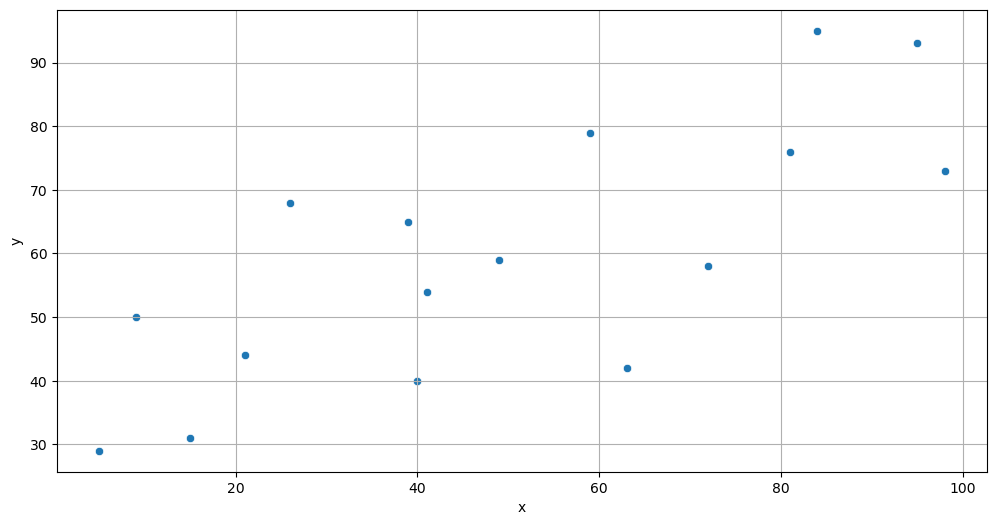

In [19]:
plt.figure(figsize = (12,6))
sns.scatterplot(x = 'x', y = 'y', data = xydf)
plt.grid()
plt.show()

### Problem 2b

Identify the optimal location of the roasting facility by minimizing the total distance from the new facility to each of the fifteen shops. 

In [20]:
model = pe.ConcreteModel()

model.x = pe.Var(domain=pe.NonNegativeReals)
model.y = pe.Var(domain=pe.NonNegativeReals)
model.x = 50
model.y = 70

data_rows = range(0,16)
model.obj = pe.Objective(expr=sum((((xydf.loc[row, 'x'] - model.x) ** 2) + (xydf.loc[row, 'y'] - model.y) ** 2) ** 0.5
                                  for row in data_rows), sense=pe.minimize)
model.pprint()

2 Var Declarations
    x : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :    50 :  None : False : False : NonNegativeReals
    y : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :    70 :  None : False : False : NonNegativeReals

1 Objective Declarations
    obj : Size=1, Index=None, Active=True
        Key  : Active : Sense    : Expression
        None :   True : minimize : ((5 - x)**2 + (29 - y)**2)**0.5 + ((9 - x)**2 + (50 - y)**2)**0.5 + ((15 - x)**2 + (31 - y)**2)**0.5 + ((21 - x)**2 + (44 - y)**2)**0.5 + ((26 - x)**2 + (68 - y)**2)**0.5 + ((59 - x)**2 + (79 - y)**2)**0.5 + ((39 - x)**2 + (65 - y)**2)**0.5 + ((40 - x)**2 + (40 - y)**2)**0.5 + ((41 - x)**2 + (54 - y)**2)**0.5 + ((49 - x)**2 + (59 - y)**2)**0.5 + ((63 - x)**2 + (42 - y)**2)**0.5 + ((72 - x)**2 + (58 - y)**2)**0.5 + ((81 - x)**2 + (76 - y)**2)**0.5 + ((84 - x)**2 + (95 - y)**2)**0.5 + ((95 - x)**2 + (93 - y

In [21]:
opt = pe.SolverFactory('ipopt')
result = opt.solve(model)
print(result.solver.status, result.solver.termination_condition)

ok optimal


In [22]:
print('The Optimal Values')
obj_val = model.obj.expr()
x_val = model.x.value
y_val = model.y.value
print(f'The optimal objective is: {obj_val:.2f}')
print(f'The optimal x value is: {x_val:.2f}')
print(f'The optimal y value is: {y_val:.2f}')

The Optimal Values
The optimal objective is: 498.84
The optimal x value is: 48.28
The optimal y value is: 58.79


### Problem 2c

Using `seaborn`, add the new location to the plot from Problem 2a. 

In [23]:
point_df = pd.DataFrame({'x': [x_val], 'y': [y_val]})

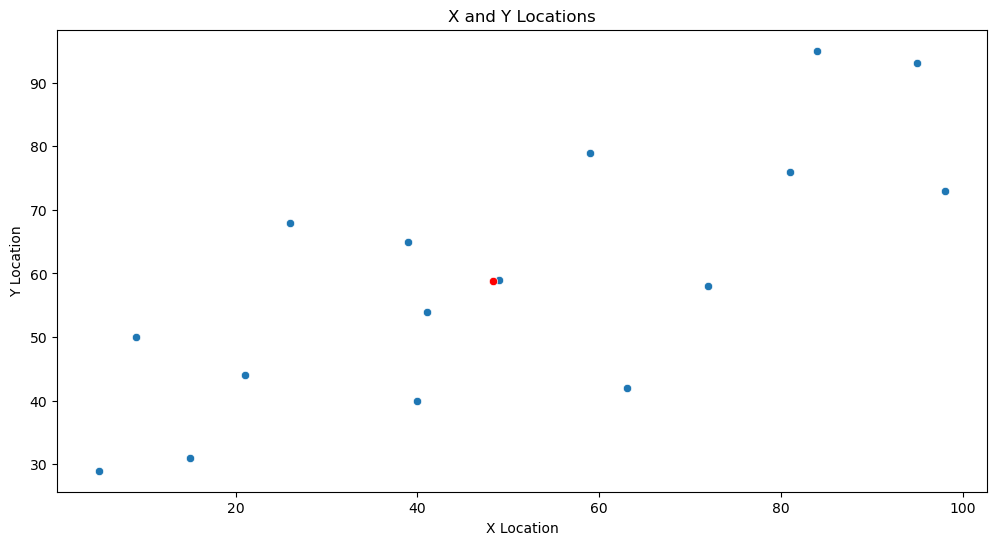

In [24]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x = 'x', y = 'y', data = xydf)
sns.scatterplot(x = 'x', y = 'y', data = point_df, color = 'red')
plt.xlabel('X Location')
plt.ylabel('Y Location')
plt.title('X and Y Locations')
plt.show()